## Train and Prediction on Valid+ data

Using rotated to hz + OpenCv border

Extra transforms

Padded BG data

added 90 training data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir_02 = Path('data_02')
data_dir = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid'

In [7]:
NB_NUM='03_24g'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: ef26ff36, DATE: 20191123


In [9]:
#DATE = '20191122'
#UID = 'dac74e4a'

In [10]:
SUB_NUM='20'

In [11]:
#wrap or reflect
border='reflect'
#padded or padded_bg
#pad_type='padded'
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/{border}/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{border}/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
len(test_names)

7325

#### useing only gold st_lucia cement

In [18]:
df_all=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [19]:
df_all.drop(columns=['target'],inplace=True)

,id
0,7a1dd158
1,7a32aa7e
2,7a3de768
3,7a2087b8
4,7a3cc4fa


In [20]:
df_valid=df_all.loc[df_all['verified'] == True]

In [21]:
df_valid.head()

,id,roof_material,verified,country,region
0,7a3f2a10,concrete_cement,True,colombia,borde_rural
1,7a1f731e,irregular_metal,True,colombia,borde_rural
2,7a424ad8,healthy_metal,True,colombia,borde_rural
3,7a3edc5e,healthy_metal,True,colombia,borde_rural
4,7a303a6e,healthy_metal,True,colombia,borde_rural


### append rotated images

In [24]:
#df_valid_rot=df_valid.copy()

In [25]:
#df_valid_rot['id'] = df_valid_rot['id'].astype(str)+'_rot90'

In [26]:
#df_valid_rot.head()

In [28]:
#cols=['id','roof_material','verified','country','region']
#df_valid_rot = df_valid_rot[cols] 

In [29]:
#df_valid_rot.head()

In [30]:
#df_valid=df_valid.append(df_valid_rot, ignore_index=True)

In [31]:
#len(df_valid)

In [32]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [33]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [34]:
df_valid.loc[df_valid['id'] == '7a204ec4']

,country,id,region,roof_material,verified
12960,guatemala,7a204ec4,mixco_1_and_ebenezer,irregular_metal,True


In [35]:
len(df_valid)

14945

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [36]:
xtra_tfms=[dihedral(p=0.5), rand_crop(p=0.4), rand_zoom(scale=(1.,1.5),p=0.4)] 
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_warp=0., xtra_tfms=xtra_tfms)


#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [37]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

14945


In [38]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [39]:
#to check what params object has
#dir(data)

In [40]:
data.label_list

LabelLists;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256

In [41]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

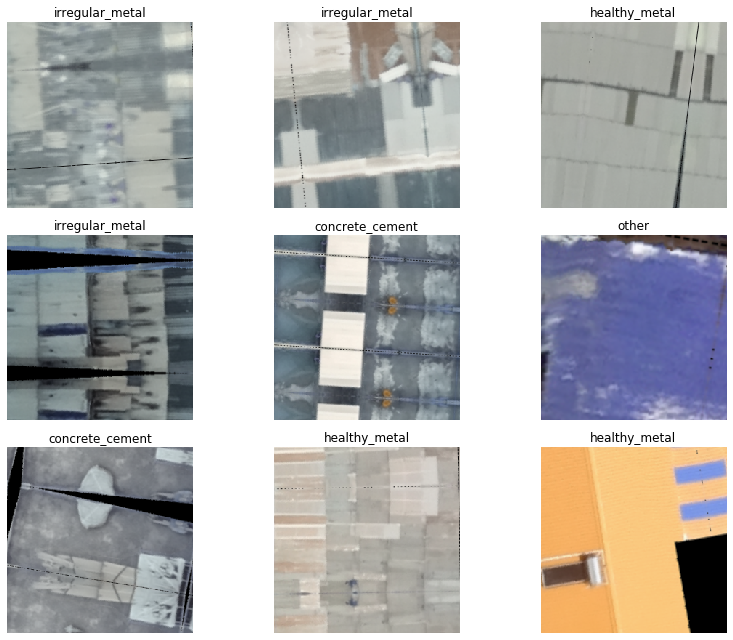

In [42]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [43]:
arch = models.resnet50
arch_name = 'rn50'

In [44]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [45]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


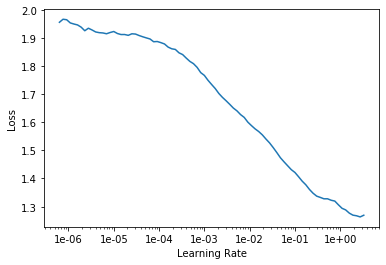

In [47]:
learn.recorder.plot()

Then we can fit the head of our network.

In [48]:
lr = 5e-3

In [49]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.948273,0.766955,0.238956,00:49
1,0.654174,0.594322,0.212182,00:42
2,0.574418,0.522449,0.202142,00:42
3,0.531872,0.522089,0.199465,00:48
4,0.512689,0.508361,0.197456,00:43


In [50]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.506953,0.513648,0.200803,00:43
1,0.510162,0.493900,0.185408,00:54
2,0.492329,0.483460,0.188755,00:51
3,0.461232,0.468425,0.190094,00:51
4,0.459889,0.468104,0.186078,00:52


In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.451826,0.475776,0.184739,00:50
1,0.485711,0.490658,0.196118,01:02


In [63]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn50-03_24-cv_reflect_101_valid-20191122-dac74e4a


In [64]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
#saves in parent of models directory
#learn.export()

In [65]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (23912 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (5978 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,irregular_metal,irregular_metal,incomplete
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, str

In [66]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.465440,0.456530,0.171295,01:18
1,0.453858,0.440051,0.168953,01:18
2,0.410114,0.426782,0.164436,01:18


In [67]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.405084,0.433076,0.164436,01:18
1,0.384013,0.423337,0.160422,01:17


In [41]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [42]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/wrap/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, strid

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 227),
 ('healthy_metal', 'irregular_metal', 138),
 ('incomplete', 'irregular_metal', 58),
 ('concrete_cement', 'healthy_metal', 28),
 ('incomplete', 'concrete_cement', 27),
 ('healthy_metal', 'concrete_cement', 19),
 ('other', 'healthy_metal', 19),
 ('concrete_cement', 'irregular_metal', 16),
 ('irregular_metal', 'concrete_cement', 16),
 ('irregular_metal', 'incomplete', 14),
 ('concrete_cement', 'incomplete', 11),
 ('incomplete', 'healthy_metal', 10),
 ('other', 'irregular_metal', 8),
 ('healthy_metal', 'incomplete', 4),
 ('irregular_metal', 'other', 2)]

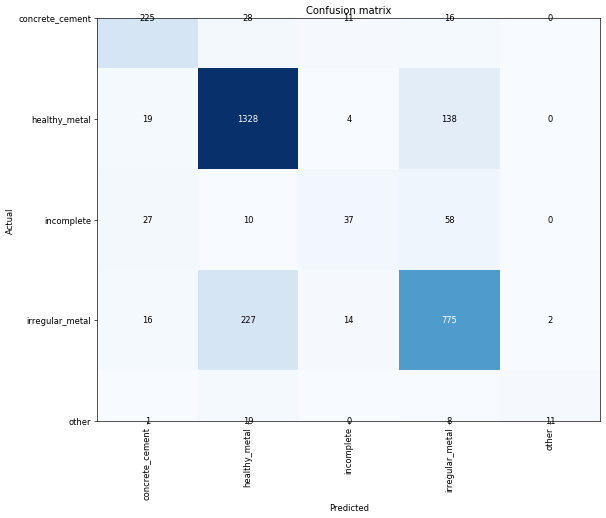

In [44]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [45]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


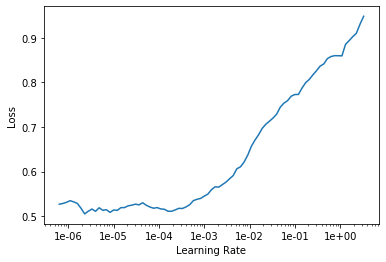

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(2e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.505712,0.550086,0.194687,01:01
1,0.491647,0.522892,0.188971,01:07
2,0.467262,0.517855,0.183591,01:04
3,0.424114,0.513982,0.184264,01:06
4,0.403958,0.509436,0.179220,01:05


In [48]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [49]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/wrap/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, strid

In [50]:
learn.fit_one_cycle(5, slice(5e-7, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.406141,0.513792,0.183927,00:55
1,0.407713,0.512465,0.185272,01:00
2,0.386744,0.528143,0.184936,01:07
3,0.356403,0.519642,0.186617,01:08
4,0.341655,0.518474,0.184936,01:06


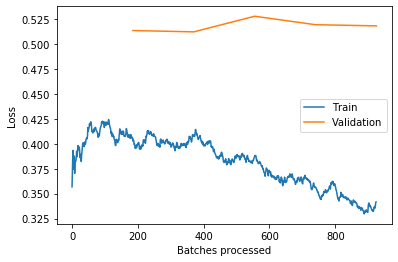

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [53]:
learn.load(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/wrap/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, strid

In [54]:
learn=learn.to_fp32()

In [55]:
learn.export()

### inference

In [56]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [57]:
len(test_dataset)

7325

In [58]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}', test=test_dataset)

In [59]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [60]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [61]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [62]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [63]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [64]:
labels = np.argmax(preds, 1)

In [65]:
len(preds)

7325

In [66]:
preds[0].tolist()

[0.043594829738140106,
 0.9360804557800293,
 0.007956314831972122,
 0.005970833823084831,
 0.0063976407982409]

In [67]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [68]:
len(labels)

7325

In [69]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [70]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [71]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [72]:
test_predictions[0]

'healthy_metal'

In [73]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [74]:
 learn.data.test_ds.x.items

array([PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a4d9168.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a4ae922.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a48ca98.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a49c614.tif'), ...,
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a486800.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a4c49fc.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a501f50.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/wrap/256/7a4d27b4.tif')], dtype=object)

In [75]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [76]:
preds_list[0]

[0.043594829738140106,
 0.9360804557800293,
 0.007956314831972122,
 0.005970833823084831,
 0.0063976407982409]

In [77]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [78]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [79]:
df.head()

,id,pred
0,7a4d9168,"[0.043594829738140106, 0.9360804557800293, 0.0..."
1,7a4ae922,"[0.007836471311748028, 0.9543949961662292, 0.0..."
2,7a48ca98,"[0.01208871603012085, 0.11990015208721161, 0.0..."
3,7a49c614,"[0.004425792954862118, 0.9489109516143799, 0.0..."
4,7a4dd4f2,"[0.017520468682050705, 0.6800229549407959, 0.0..."


In [80]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [81]:
pred_df.insert(loc=0, column='id', value=ids)

In [82]:
pred_df.columns = cols

In [83]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.043595,0.936080,0.007956,0.005971,0.006398
1,7a4ae922,0.007836,0.954395,0.005787,0.022758,0.009224
2,7a48ca98,0.012089,0.119900,0.047824,0.812746,0.007442
3,7a49c614,0.004426,0.948911,0.007069,0.034821,0.004773
4,7a4dd4f2,0.017520,0.680023,0.019409,0.256931,0.026116


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [84]:
pred_ids=pred_df['id'].values.tolist()

In [85]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

FileNotFoundError: [Errno 2] File b'data_02/submissions/mean_baseline.csv' does not exist: b'data_02/submissions/mean_baseline.csv'

In [ ]:
df_baseline.head()

In [ ]:
baseline_ids=df_baseline['id'].values.tolist()

In [ ]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [ ]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [ ]:
pred_df.head()

In [ ]:
pred_df=pred_df.sort_values('id_cat')

In [ ]:
pred_df.head()

In [ ]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [ ]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 2: 0.4687


In [ ]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")